!pip install kneed

In [4]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt
import base64
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile

In [3]:
tracks_ready=pd.read_csv('tracks_ready.csv',sep=',')
tracks_ready=tracks_ready[['id','centroid_lon','centroid_lat','start_dttm','final_part_of_day_in_word','weekend','start_dttm_day']]
tracks_ready_small=tracks_ready[['id','centroid_lon','centroid_lat','start_dttm','final_part_of_day_in_word','weekend','start_dttm_day']]

In [7]:
customers=np.unique(tracks_ready_small['id'])

In [ ]:
ids=[]
clusters_list=[]
kneedle_list=[]
i=1
for id in customers:
    if len(tracks_ready_small[tracks_ready_small['id']==id])==1:
        ids.append([id]*len(tracks_ready_small[tracks_ready_small['id']==id]))
        clusters_list.append([1]*len(tracks_ready_small[tracks_ready_small['id']==id]))
        kneedle_list.append([0]*len(tracks_ready_small[tracks_ready_small['id']==id]))
    else:
        if len(tracks_ready_small[tracks_ready_small['id']==id])<5:
            nbrs = NearestNeighbors(n_neighbors = len(tracks_ready_small[tracks_ready_small['id']==id])).fit(tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']])
        else:
            # n_neighbors = 5 as kneighbors function returns distance of point to itself (i.e. first column will be zeros)
            nbrs = NearestNeighbors(n_neighbors = 5).fit(tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']])
        # Find the k-neighbors of a point
        neigh_dist, neigh_ind = nbrs.kneighbors(tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']])
        # sort the neighbor distances (lengths to points) in ascending order
        # axis = 0 represents sort along first axis i.e. sort along row
        sort_neigh_dist = np.sort(neigh_dist, axis = 0)
        try:
            k_dist = sort_neigh_dist[:, 2]
        except IndexError:
            k_dist = sort_neigh_dist[:, 1]
        kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, 
                            curve = "concave", direction = "increasing", online=True)
        try:
            if kneedle.knee_y>0.003:
                kneedle_cuurent=kneedle.knee_y
            else:
                kneedle_cuurent=0.003
            clusters = DBSCAN(eps = kneedle_cuurent, min_samples = 1).fit(tracks_ready_small[tracks_ready_small['id']==id][['centroid_lon','centroid_lat']])    
            ids.append([id]*len(tracks_ready_small[tracks_ready_small['id']==id]))
            clusters_list.append(clusters.labels_)
            kneedle_list.append([kneedle_cuurent]*len(tracks_ready_small[tracks_ready_small['id']==id]))
        except TypeError:
            ids.append([id]*len(tracks_ready_small[tracks_ready_small['id']==id]))
            clusters_list.append([1]*len(tracks_ready_small[tracks_ready_small['id']==id]))
            kneedle_list.append([0]*len(tracks_ready_small[tracks_ready_small['id']==id]))



In [9]:
import itertools
ids_list2 = list(itertools.chain(*ids))
clusters=list(itertools.chain(*clusters_list))
kn=list(itertools.chain(*kneedle_list))
clustering_result=pd.DataFrame(ids_list2,columns=['id'])
clustering_result['clusters']=clusters
clustering_result['kneedle']=kn
clustering_result['help']=1
tracks_ready_small['help']=1

In [11]:
checking_df=pd.pivot_table(tracks_ready_small,index='id',values='help',aggfunc=sum).merge(pd.pivot_table(clustering_result,index='id',values='help',aggfunc=sum),on='id')
checking_df['correct_result']=checking_df['help_x']==checking_df['help_y']
checking_df[checking_df['correct_result']==False]

Empty DataFrame
Columns: [help_x, help_y, correct_result]
Index: []

In [12]:
clustering_result.columns

Index(['id', 'clusters', 'kneedle', 'help'], dtype='object')

In [13]:
tracks_ready['clusters_settl']=clustering_result['clusters']
tracks_ready['kneedle']=clustering_result['kneedle']


In [14]:
def find_dist1(lat1,lon1,lat2,lon2):
    try:
        lat1=lat1/57.36049
        lat2=lat2/57.36049
        lon1=lon1/57.36049
        lon2=lon2/57.36049
        return 2*6371*np.arcsin((np.sin((lat2-lat1)/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin((lon1-lon2)/2)**2)**0.5)

    except ValueError:
        return 0

In [15]:
tracks_ready['eps']=list(map(find_dist1,[0]*len(tracks_ready),[0]*len(tracks_ready),tracks_ready['kneedle'],[0]*len(tracks_ready)))


[]

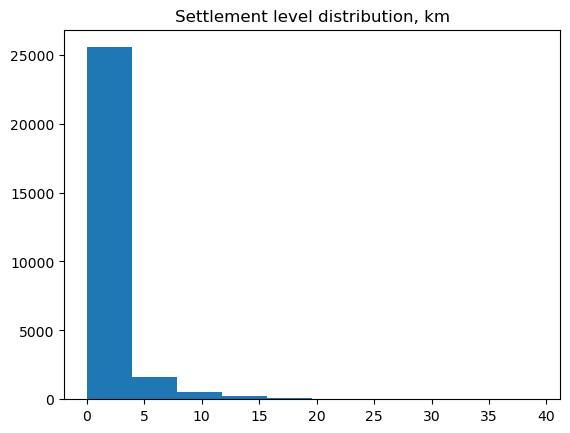

In [17]:
plt.hist(tracks_ready.drop_duplicates(subset='id')['eps'])
plt.title('Settlement level distribution, km')
plt.plot()

In [18]:
tracks_ready.drop_duplicates(subset='id')[['eps','kneedle']].describe()

eps       kneedle
count  28017.000000  28017.000000
mean       1.319042      0.011876
std        2.595054      0.023364
min        0.000000      0.000000
25%        0.333208      0.003000
50%        0.333208      0.003000
75%        1.127089      0.010148
max       39.224709      0.353155

In [20]:
tracks_ready['help']=1
num_of_id_clusters=pd.pivot_table(tracks_ready.drop_duplicates(subset=('id','clusters_settl')),index='id',values='help',aggfunc=sum).reset_index()
num_of_id_clusters.columns=['id','num_of_id_clusters']

tracks_ready=tracks_ready.merge(num_of_id_clusters,on='id')


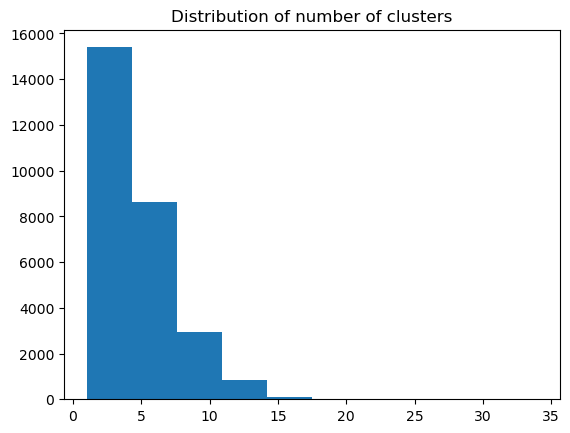

In [21]:
plt.hist(num_of_id_clusters['num_of_id_clusters'])
plt.title('Distribution of number of clusters')
plt.show()

In [22]:
num_of_id_clusters['num_of_id_clusters'].describe()

count    28017.000000
mean         4.498376
std          2.933699
min          1.000000
25%          2.000000
50%          4.000000
75%          6.000000
max         34.000000
Name: num_of_id_clusters, dtype: float64

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np


distortions = []


for k in range(1, 11):
    kmeanModel = KMeans(n_clusters=k).fit(tracks_ready['eps'].values.reshape(-1,1))
    kmeanModel.fit(tracks_ready['eps'].values.reshape(-1,1))
    distortions.append(sum(np.min(cdist(tracks_ready['eps'].values.reshape(-1,1), kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / tracks_ready['eps'].values.reshape(-1,1).shape[0])

# Plot the elbow graph
plt.plot(range(1, 11), distortions, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show() 

In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
kmeans.fit(tracks_ready['eps'].values.reshape(-1,1))


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [26]:
tracks_ready['5 clusters for settlement level']=kmeans.labels_

In [28]:
pd.pivot_table(tracks_ready,index='5 clusters for settlement level',values=('eps','help'),aggfunc={'eps':'mean','help':sum}).sort_values('help')

eps    help
5 clusters for settlement level                   
4                                20.861980    5405
1                                10.777447   25102
2                                 5.596821   70473
3                                 2.434677  171981
0                                 0.500568  864841

# For different time zones in day

In [ ]:
for pds in np.unique(tracks_ready['final_part_of_day_in_word']):
    df_s=tracks_ready[tracks_ready['final_part_of_day_in_word']==pds][['centroid_lon','centroid_lat','id','start_dttm','final_part_of_day_in_word']]
    X=tracks_ready[tracks_ready['final_part_of_day_in_word']==pds][['centroid_lon','centroid_lat']]
    nbrs = NearestNeighbors(n_neighbors = 5).fit(X)
    neigh_dist, neigh_ind = nbrs.kneighbors(X)
    sort_neigh_dist = np.sort(neigh_dist, axis = 0)
    k_dist = sort_neigh_dist[:, 2]
    kneedle = KneeLocator(x = range(1, len(neigh_dist)+1), y = k_dist, 
                        curve = "concave", direction = "increasing", online=True)
    #kneedle_cuurent=kneedle.knee_y
    kneedle_current=0.003 
    clusters = DBSCAN(eps = kneedle_current, min_samples = 1).fit(X)    
    df_s[pds]=clusters.labels_
    tracks_ready=pd.merge(tracks_ready,df_s, how='left',on=['centroid_lon','centroid_lat','id','start_dttm','final_part_of_day_in_word'])
    print(pds)



In [166]:
for col in np.unique(tracks_ready['final_part_of_day_in_word']):
    print(len(np.unique(tracks_ready[col])))
    

914
1114
1302
1402
1010
820


In [34]:
tracks_ready['count']=1

In [169]:
pd.pivot_table(tracks_ready,index='working hours',values='help',aggfunc=sum).sort_values(by='help')

help
working hours        
818.0               1
561.0               1
562.0               1
563.0               1
564.0               1
...               ...
10.0             2033
120.0            2091
22.0             3071
1.0              3336
0.0            478705

[819 rows x 1 columns]

In [192]:
for pds in np.unique(tracks_ready['final_part_of_day_in_word']): 
    df_s=tracks_ready[tracks_ready['final_part_of_day_in_word']==pds][['centroid_lon','centroid_lat','id','start_dttm','final_part_of_day_in_word']]
    X=tracks_ready[tracks_ready['final_part_of_day_in_word']==pds][['centroid_lon','centroid_lat']]
    kmeans = KMeans(n_clusters=100)
    kmeans.fit(X)    
    df_s[pds]=kmeans.labels_
    tracks_ready=pd.merge(tracks_ready,df_s, how='left',on=['centroid_lon','centroid_lat','id','start_dttm','final_part_of_day_in_word'])
    print(pds)



/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



evening


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



morning


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



night


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



whole day


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



whole day end


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



working hours


In [193]:
tracks_ready['clusters_by_day_part']=tracks_ready['evening'].replace(np.nan,0)+tracks_ready['morning'].replace(np.nan,0)+tracks_ready['night'].replace(np.nan,0)+tracks_ready['whole day'].replace(np.nan,0)+tracks_ready['whole day end'].replace(np.nan,0)+tracks_ready['working hours'].replace(np.nan,0)

In [196]:
pd.pivot_table(tracks_ready,index='final_part_of_day_in_word',columns='clusters_by_day_part',values='help',aggfunc=sum)

clusters_by_day_part       0.0   1.0   2.0   3.0   4.0   5.0   6.0   7.0   \
final_part_of_day_in_word                                                   
evening                    2570  2127  2171  2909  1410  2486  1527  1424   
morning                    1521  1786  1047  1221  1533  1358   904  2461   
night                      1789  1427  1332  1209  2012  1720   705  1055   
whole day                   318    85   442   262   143   284   194   303   
whole day end              1568  1570   418  1825  2425  2349  3472  2252   
working hours              5078  4210  6082  5930  7430  4369  3801  1985   

clusters_by_day_part       8.0   9.0   ...  90.0  91.0  92.0  93.0  94.0  \
final_part_of_day_in_word              ...                                 
evening                    2188  3550  ...  2408  1391  1483  2114  1852   
morning                     975  1071  ...   956   751  1741  2235  1897   
night                      1344   796  ...   815   678   925  1386   467   
whole day                   220   124  ...   200   291    43   143   169   
whole day end              1596  2038  ...   976  1257   521  1637   640   
working hours              9620  1407  ...  5237  6178  3263  7536  2048   

clusters_by_day_part       95.0  96.0  97.0  98.0  99.0  
final_part_of_day_in_word                                
evening                    1615  1533  1142  1124   298  
morning                    1379  1159  1075   940   823  
night                      1611  1919  1667   438  1097  
whole day                    61   308   192   178   346  
whole day end              1982  1450  2072  1100  2136  
working hours              5176  8749  4151  1250  4445  

[6 rows x 100 columns]

In [ ]:
#plt.scatter(tracks_ready[(tracks_ready['final_part_of_day_in_word']=='working hours')&(tracks_ready[tracks_ready['working hours']==14])]['centroid_lat'],tracks_ready[(tracks_ready['final_part_of_day_in_word']=='working hours')&(tracks_ready[tracks_ready['working hours']==14])]['centroid_lon'])

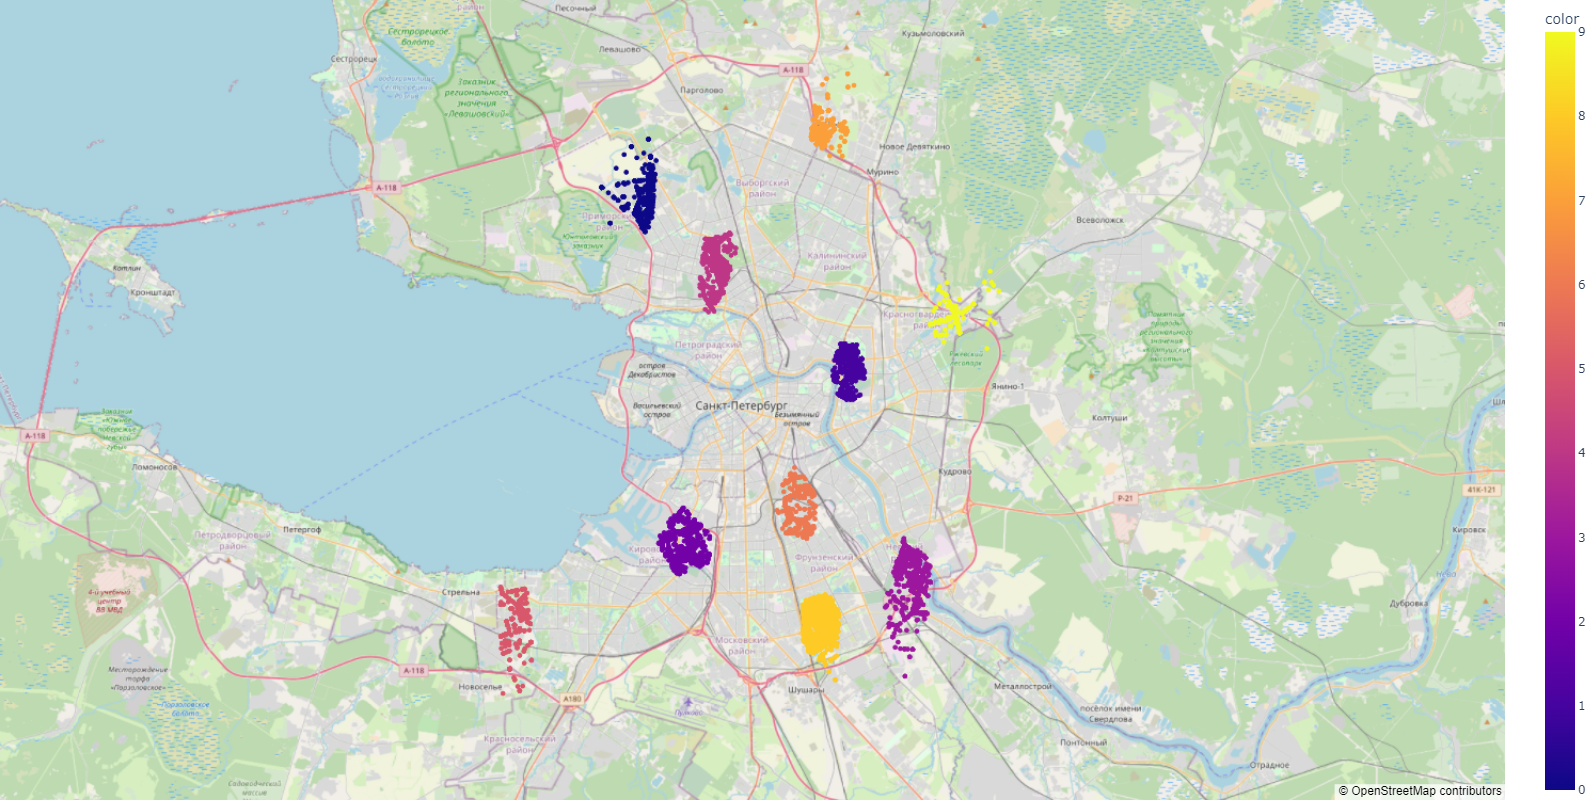

In [200]:

import plotly.express as px

color_scale = [(0, 'orange'), (1,'red')]
id=455266533855
#print(pd.pivot_table(tracks_ready[tracks_ready['final_part_of_day_in_word']=='working hours'],index='clusters_settl',values='help',aggfunc=sum))
#print(pd.pivot_table(tracks_ready[tracks_ready['id']==id],index='5 clusters for settlement level',values='help',aggfunc=sum))

fig1 = px.scatter_mapbox(tracks_ready[(tracks_ready['final_part_of_day_in_word']=='working hours')&(tracks_ready['clusters_by_day_part']<10)][['centroid_lon','centroid_lat']], 
                        lat='centroid_lat', 
                        lon='centroid_lon', 
                        #hover_name="name", 
                        #hover_data=["name"],
                        color=tracks_ready[(tracks_ready['final_part_of_day_in_word']=='working hours')&(tracks_ready['clusters_by_day_part']<10)]['clusters_by_day_part'],
                        #color_continuous_scale=color_scale,
                        #size=tracks_ready[tracks_ready['id']==id]['clusters_settl'].values,
                        zoom=8, 
                        height=800,
                        width=800)

fig1.update_layout(mapbox_style="open-street-map")
fig1.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig1.show()

In [ ]:
len(tracks_ready[(tracks_ready['final_part_of_day_in_word']=='working hours')&(tracks_ready[tracks_ready['working hours']==14])]['centroid_lat'])

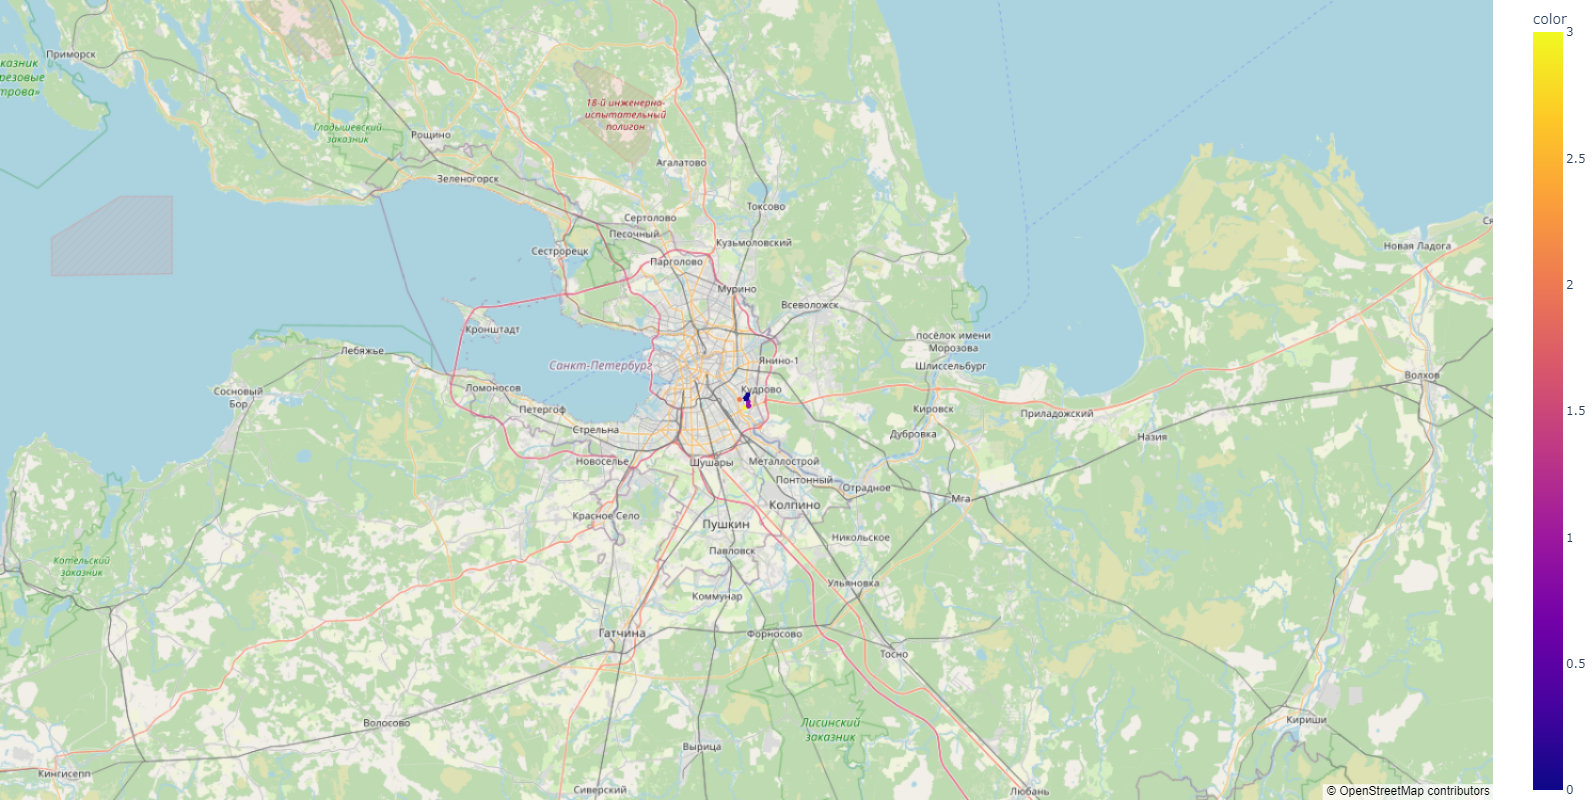

In [39]:

import plotly.express as px

color_scale = [(0, 'orange'), (1,'red')]
id=13
#print(pd.pivot_table(tracks_ready[tracks_ready['final_part_of_day_in_word']=='working hours'],index='clusters_settl',values='help',aggfunc=sum))
#print(pd.pivot_table(tracks_ready[tracks_ready['id']==id],index='5 clusters for settlement level',values='help',aggfunc=sum))

fig1 = px.scatter_mapbox(tracks_ready[(tracks_ready['id']==id)][['centroid_lon','centroid_lat']], 
                        lat='centroid_lat', 
                        lon='centroid_lon', 
                        #hover_name="name", 
                        #hover_data=["name"],
                        color=tracks_ready[tracks_ready['id']==id]['clusters_settl'].values,
                        #color_continuous_scale=color_scale,
                        #size=tracks_ready[tracks_ready['id']==id]['clusters_settl'].values,
                        zoom=8, 
                        height=800,
                        width=800)

fig1.update_layout(mapbox_style="open-street-map")
fig1.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig1.show()